In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 家電  

## 冷蔵庫

### 時刻別消費電力量
$$
E_{ Elc, rfrg, d, t } = 
\begin{cases}
P_{ Elc, dfrst, rtd } \times C_{ dfrst } \times 1  \times 10^{ -3 } & (t = 0, 23) \\
P_{ Elc, rfrg, oprt, d } \times 1 \times 10^{ -3 } & (それ以外)
\end{cases}
$$

$ E_{ Elc, rfrg, d, t } $：日付dの時刻tにおける消費電力量, kWh/h  
$ P_{ Elc, dfrst, rtd } $：除霜用電熱装置の定格消費電力( = 150 ),W  
$ C_{ dfrst } $：除霜用電熱装置の消費電力量の評価係数( = 0.9 ),-  
$ 1 $：1時間(消費電力を消費電力量に換算するための数値),h  
$ P_{ Elc, rfrg, oprt, ave } $：日付dにおける稼働時における平均消費電力,W

In [2]:
def get_E_Elc_rfrg_d_t(P_Elc_dfrst_rtd, C_dfrst, theta_ave_d, E_Elc_rfrg_annual_JIS, JIS_year):
    """時刻別消費電力量を計算する
    
    Parameters
    ----------
    P_Elc_dfrst_rtd : float
        除霜用電熱装置の定格消費電力( = 150 ), W
    
    C_dfrst : float
        除霜用電熱装置の消費電力量の評価係数( = 0.9 ), -
    
    theta_ave_d : ndarray(N-dimensional array)
        日別の平均外気温度を格納したND配列, ℃
        d日の平均外気温度が年開始日から365個連続して格納されている
    
    E_Elc_rfrg_annual_JIS : float
        JISに準拠して測定された年間消費電量, kWh
        
    JIS_year : Int
        年間消費電力量の測定時に準拠したJIS規格の制定・改正年, 年
    
    Returns
    ----------
    E_Elc_rfrg_d_t : ndarray(N-dimensional array)
        1年間の全時間の消費電力量を格納したND配列, Wh
        d日t時の消費電力量が年開始時から8760個連続して格納されている
    """
    
    theta_amb_ave_d = get_theta_amb_ave_d(theta_ave_d)
    E_Elc_rfrg_annual = get_E_Elc_rfrg_annual(E_Elc_rfrg_annual_JIS, JIS_year)
    P_Elc_rfrg_oprt_ave_d = get_P_Elc_rfrg_oprt_ave_d(E_Elc_rfrg_annual, theta_amb_ave_d)

    rfrg_dfrst_d = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
    rfrg_oprt_d  = [0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]
    
    rfrg_dfrst_d_t = np.tile(rfrg_dfrst_d, 365)
    rfrg_oprt_d_t  = np.tile(rfrg_oprt_d, 365)
    
    E_Elc_rfrg_dfrst_d_t = rfrg_dfrst_d_t * P_Elc_dfrst_rtd * C_dfrst * 1 * 10**(-3)
    P_Elc_rfrg_oprt_ave_d_t = np.array([])
    for p in P_Elc_rfrg_oprt_ave_d: 
        P_Elc_rfrg_oprt_ave_d_t = np.append(P_Elc_rfrg_oprt_ave_d_t, np.tile(p, 24))
    E_Elc_rfrg_oprt_d_t = rfrg_oprt_d_t * P_Elc_rfrg_oprt_ave_d_t * 1 *10**(-3)

    E_Elc_rfrg_d_t = E_Elc_rfrg_dfrst_d_t + E_Elc_rfrg_oprt_d_t
    
    return E_Elc_rfrg_d_t

### 稼働時の平均消費電力  
$$
P_{ Elc, rfrg, oprt, ave, d } = 
\frac
{ E_{ Elc, rfrg, est, d } }
{ t_{ rfrg, oprt } } 
$$
$$
\begin{eqnarray*}
E_{ Elc, rfrg, est, d } 
& = & 
[
(3.283 \times 10^{ -3 } - 2.0 \times 10^{ -6 } \times E_{ Elc, rfrg, annual } ) 
\times ( \theta_{ amb, ave, d}^2 - 30 \times \theta_{ amb, ave, d } ) \\
& \quad & + 1.85 \times 10^{ -3 } \times E_{ Elc, rfrg, annual} \\
& \quad & + 1.329
]
\times 10^3
\end{eqnarray*}
$$

$ E_{ Elc, rfrg, est, d } $：日付dにおける推定日積算消費電力量,kWh  
$ t_{ rfrg, oprt } $：1日当たりの稼働時間数( = 22 ),h  
$ E_{ Elc, rfrg, annual } $：年間消費電力量,kWh  
$ \theta_{ amb, ave, d } $：日付dにおける冷蔵庫の周辺空気の日平均温度,℃  


In [3]:
def get_P_Elc_rfrg_oprt_ave_d(E_Elc_rfrg_annual, theta_amb_ave_d):
    
    """
    Parameters
    ----------
    E_Elc_rfrg_annual : float
        年間消費電量, kWh
        
    theta_amb_d : ndarray(N-dimensional array)
        1年間の冷蔵庫の周辺空気の日平均温度を格納したND配列, ℃
        d日の冷蔵庫の周辺空気の日平均温度が年開始時から365個連続して格納されている
    
    Returns
    ----------
    P_Elc_rfrg_oprt_ave_d : ndarray(N-dimensional array)
        1年間の稼働時の平均消費電力を格納したND配列, W
        d日の稼働時の平均消費電力が年開始時から365個連続して格納されている
    """
    
    P_Elc_rfrg_est_d = \
        ( \
            (3.283 * 10**(-3) - 2.0 * 10**(-6) * E_Elc_rfrg_annual) \
            * (theta_amb_ave_d**2 - 30 * theta_amb_ave_d) \
            + 1.85 * 10**(-3) * E_Elc_rfrg_annual \
            + 1.329 \
        ) * 10**3
    
    P_Elc_rfrg_oprt_ave_d = P_Elc_rfrg_est_d / 22
    
    return P_Elc_rfrg_oprt_ave_d

### 冷蔵庫の周辺空気の日平均温度
$$
\theta_{ amb, ave, d } = 
0.4142 \times \theta_{ oa, ave, d } + 15.47
$$

$ \theta_{ oa, ave, d } $：日付dにおける日平均外気温度,℃

In [4]:
def get_theta_amb_ave_d(theta_ave_d):
    """時刻別消費電力量を計算する
    
    Parameters
    ----------
    theta_ave_d : ndarray(N-dimensional array)
        1年間の外気の日平均温度[℃]を格納したND配列
        d日の外気の日平均温度(＝14.6通年で一定値)[℃]が年開始時から365個連続して格納されている
        
    Returns
    ----------
    theta_amb_d : ndarray(N-dimensional array)
        1年間の冷蔵庫の周辺空気の日平均温度[℃]を格納したND配列
        d日の冷蔵庫の周辺空気の日平均温度[℃]が年開始時から365個連続して格納されている
    """

    theta_amb_ave_d = 0.4142 * theta_ave_d + 15.47
    
    return theta_amb_ave_d

### 冷蔵庫の年間消費電力量 
 
$$
E_{ Elc, rfrg, annual } = 
\begin{cases}
E_{  Elc, rfrg, annual, JIS1999 } & (\mbox{JIS C 9801:1999})　\\
\frac{ E_{ Elc, rfrg, annual, JIS2006 } }{ 3.48 } & (\mbox{JIS C 9801:2006})　\\
\frac{ E_{  Elc, rfrg, annual, JIS2015 } }{ 3.48 }  \times 0.2891 & (\mbox{JIS C 9801:2015})
\end{cases}
$$
  
$ E_{ Elc, rfrg, annual, JIS1999 } $：JIS C 9801：1999に基づく年間消費電力量,kWh  
$ E_{ Elc, rfrg, annual, JIS2006 } $：JIS C 9801：2006に基づく年間消費電力量,kWh  
$ E_{ Elc, rfrg, annual, JIS2015 } $：JIS C 9801：2015に基づく年間消費電力量,kWh

In [5]:
def get_E_Elc_rfrg_annual(E_Elc_rfrg_annual_JIS,JIS_year):
    """時刻別消費電力量を計算する
    
    Parameters
    ----------
    E_Elc_rfrg_annual_JIS : float
        JISに準拠して測定された年間消費電量[kWh]
        
    JIS_year : Int
        年間消費電力量の測定時に準拠したJIS規格の制定年[年]
        
    Returns
    ----------
    E_Elc_rfrg_annual : float
        年間消費電量[kWh]
    """
    
    if JIS_year == 1999:
        E_Elc_rfrg_annual = E_Elc_rfrg_annual_JIS
    elif JIS_year == 2006:
        E_Elc_rfrg_annual = E_Elc_rfrg_annual_JIS / 3.48
    elif JIS_year == 2015:
        E_Elc_rfrg_annual = E_Elc_rfrg_annual_JIS / 3.48 * 0.2891
    else:
        raise ValueError(JIS_year)
    
    return E_Elc_rfrg_annual

## サンプル計算

### 外気条件の読み込み
ここでは、サンプルデータをcsvファイルから読み込む

In [6]:
def import_theta_ex_d() -> np.ndarray:
    """
    日平均外気温度を外部CSVファイルからND配列に読み込む
    Returns:
        theta_ext_d : 日平均外気温度[365], ℃ 
    """
#    df = pd.read_csv('external_air_temperature_sample.csv', encoding='SHIFT_JIS')
    df = pd.read_csv('external_air_temperature_constant_value.csv', encoding='SHIFT_JIS')
    ds = df['日平均外気温度[℃]']
    theta_ext_d = ds.values
    return theta_ext_d

### 冷蔵庫の年間消費電力量

In [7]:
get_E_Elc_rfrg_annual(6.1, 2015)

0.5067557471264368

### 冷蔵庫の周辺空気の日平均温度

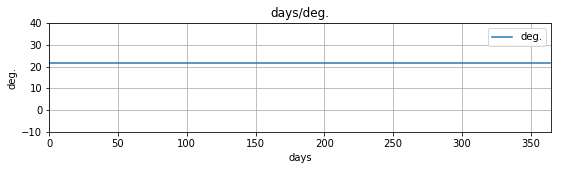

In [8]:
x = np.arange(365)
y = get_theta_amb_ave_d(import_theta_ex_d())

plt.figure(figsize=(9,2))
plt.subplot(1,1,1)
plt.plot(x, y, label="deg.")

plt.grid(True)

plt.title("days/deg.")
plt.xlabel("days")
plt.ylabel("deg.")

plt.xlim(0,365)
plt.ylim(-10,40)

plt.legend()
plt.show()


### 稼働時の平均消費電力 

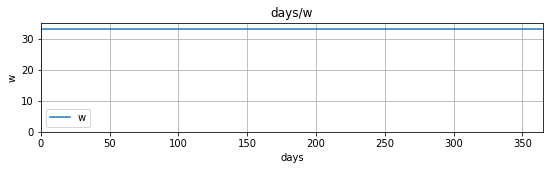

In [9]:
x = np.arange(365)
y = get_P_Elc_rfrg_oprt_ave_d(get_E_Elc_rfrg_annual(6.1, 2015), get_theta_amb_ave_d(import_theta_ex_d()))

plt.figure(figsize=(9,2))
plt.subplot(1,1,1)
plt.plot(x, y, label="w")

plt.grid(True)

plt.title("days/w")
plt.xlabel("days")
plt.ylabel("w")

plt.xlim(0,365)
plt.ylim(0)

plt.legend()
plt.show()


### 時刻別消費電力量

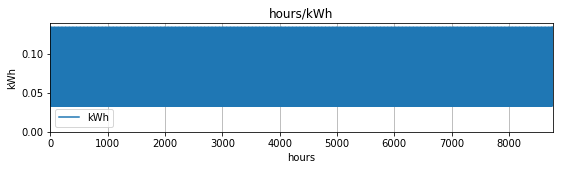

In [10]:
x = np.arange(8760)
y = get_E_Elc_rfrg_d_t(150,0.9,import_theta_ex_d(),6.1,2015)

plt.figure(figsize=(9,2))
plt.subplot(1,1,1)
plt.plot(x, y, label="kWh")

plt.grid(True)

plt.title("hours/kWh")
plt.xlabel("hours")
plt.ylabel("kWh")

plt.xlim(0,8760)
plt.ylim(0,)

plt.legend()
plt.show()

### 省エネ基準との比較用時刻別消費電力量の書き出し

In [11]:
dat = get_E_Elc_rfrg_d_t(150,0.9,import_theta_ex_d(),330,2006)
np.savetxt('ref.csv',dat,delimiter=',',fmt = " %s ")

dat

array([ 0.135     ,  0.04271908,  0.04271908, ...,  0.04271908,
        0.04271908,  0.135     ])